# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [15]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [16]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX_API_KEY")

# Import Data

In [17]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [23]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    # YOUR CODE HERE!
    mean_housing_units = sfo_data['housing_units'].groupby('year').mean()
    housing_units_std = sfo_data['housing_units'].std()
    housing_units_min = mean_housing_units.min()
    housing_units_max = mean_housing_units.max()
    lower_bound = housing_units_min - housing_units_std
    upper_bound = housing_units_max + housing_units_std
    return mean_housing_units.hvplot.bar(title = 'Housing Units in San Francisco from 2010 to 2016',
                                            rot = 90
                                           ).opts(ylim=(lower_bound, upper_bound), yformatter = '%.0f',
                                                  xlabel = 'Year', ylabel = 'Housing Units'
                                                 )

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    # YOUR CODE HERE!
    averages_1 = sfo_data['gross_rent'].groupby('year').mean()
    line_plot_gross_rent = averages_1.plot(kind = 'line')
    line_plot_gross_rent.set_xlabel('Year')
    line_plot_gross_rent.set_ylabel('Average Gross Rent')
    line_plot_gross_rent.set_title(label = 'Average Gross Rent In San Francisco', fontsize=15, fontweight="bold")
    return line_plot_gross_rent

def average_sales_price():
    """Average Sales Price Per Year."""
    
    # YOUR CODE HERE!
    averages_2 = sfo_data[['sale_price_sqr_foot', 'gross_rent']].groupby('year').mean()
    plot_sales = averages_2['sale_price_sqr_foot']
    line_plot_sales = plot_sales.plot(kind = 'line')
    line_plot_sales.set_xlabel('Year')
    line_plot_sales.set_ylabel('Average Sales Price')
    line_plot_sales.set_title(label = 'Average Sales Price per Square Foot In San Francisco', fontsize=13, fontweight="bold")
    return line_plot_sales

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    # YOUR CODE HERE!
    avg_table = sfo_data.groupby([sfo_data.index,'neighborhood']).mean().reset_index()
    avg_sqft_price = avg_table.hvplot.line(
    "year",
    "sale_price_sqr_foot",
    xlabel = "Year",
    ylabel = "Avg. Sale price",
    groupby = "neighborhood")
                                                                                                     
    return avg_sqft_price

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    
    
    # YOUR CODE HERE!
    top_10_values = sfo_data.groupby('neighborhood').mean()
    top_10_values = top_10_values.sort_values('sale_price_sqr_foot', ascending = False)
    top_10_values = top_10_values.reset_index()
    top_10_neighborhood = top_10_values.iloc[:10,]
    top_10_neighborhood = top_10_neighborhood.hvplot.bar(
    "neighborhood",
    "sale_price_sqr_foot",
    xlabel = "Neighborhood",
    ylabel = "Sale Price Square Foot",
    rot = 90
    ).opts(title = 'Top 10 Expensive Neighborhoods in SFO') 
    return top_10_neighborhood

def parallel_coordinates():
    """Parallel Coordinates Plot."""
    
    # YOUR CODE HERE!
    top_10_values = sfo_data.groupby('neighborhood').mean()
    top_10_values = top_10_values.sort_values('sale_price_sqr_foot', ascending = False)
    top_10_values = top_10_values.reset_index()
    top_10_neighborhood = top_10_values.iloc[:10,]
    parallel_plot = px.parallel_coordinates(top_10_neighborhood)
    return parallel_plot

def parallel_categories():
    """Parallel Categories Plot."""
    
    # YOUR CODE HERE!
    top_10_values = sfo_data.groupby('neighborhood').mean()
    top_10_values = top_10_values.sort_values('sale_price_sqr_foot', ascending = False)
    top_10_values = top_10_values.reset_index()
    top_10_neighborhood = top_10_values.iloc[:10,]
    plot_categories = px.parallel_categories(
    top_10_neighborhood,
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
    labels={
        "neighborhood": "Neighborhood",
        "sale_price_sqr_foot": "sale_price_sqr_foot",
        "housing_units": "housing_units",
        "gross_rent" : "gross_rent"
    },)
    return plot_categories

def neighborhood_map():
    """Neighborhood Map"""
    
    # YOUR CODE HERE!
    mean_values = sfo_data.groupby('neighborhood').mean().reset_index()
    final_table = pd.concat([df_neighborhood_locations, mean_values], axis = 'columns', join = 'inner')
    final_table.pop('neighborhood')
    map_1 = px.scatter_mapbox(
    final_table,
    lat="Lat",
    lon="Lon",
    color="gross_rent",
    size = "sale_price_sqr_foot",
    color_continuous_scale=px.colors.cyclical.IceFire,
    mapbox_style="carto-positron")
    return map_1

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

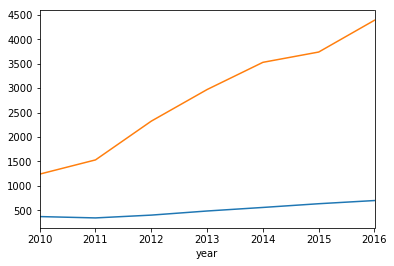

In [24]:
# YOUR CODE HERE!
Map = pn.Column('All About San Francisco Housing Prices', neighborhood_map())
coordinates = pn.Column('Cool Graphs, Right?', parallel_categories(), parallel_coordinates())
Most_expensive_and_avg = pn.Column('10 Most Expensive Neighborhoods and Average Prices', top_most_expensive_neighborhoods(), average_price_by_neighborhood())
Basic_info = pn.Column('Other Interesting Stats', average_sales_price(), average_gross_rent(), housing_units_per_year())
dashboard = pn.Tabs(
    ('Overview', Map), ('Interesting Relations', coordinates), ('Most Expensive and Average', Most_expensive_and_avg),
    ('Basic Information', Basic_info)
)


## Serve the Panel Dashboard

In [25]:
dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
    [2] Column
        [0] Markdown(str)
        [1] HoloViews(Bars)
        [2] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
    [3] Column
        [0] Markdown(str)
        [1] Str(AxesSubplot)
        [2] Str(AxesSubplot)
        [3] HoloViews(Bars)